<a href="https://colab.research.google.com/github/Farhan-hyd/Ml-Notebook/blob/main/ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ML Notebook

In [155]:
'''
Installations of packages in colab
'''

!pip install talib-binary &> /dev/null
!pip install yfinance &> /dev/null

In [156]:
#basic libraries
import numpy as np
import pandas as pd

#libraries to load dataset
import yfinance as yf # https://pypi.org/project/yfinance/
from pandas_datareader import data as pdr #https://pypi.org/project/pandas-datareader/
import talib as ta # https://pypi.org/project/talib-binary/

from sklearn.model_selection import train_test_split

In [157]:
#load dataset of google stocks from 2000-01-01 to 2018-01-01
yf.pdr_override()
df = pdr.get_data_yahoo('GOOG', '2000-01-01', '2018-01-01')

[*********************100%***********************]  1 of 1 completed


##Preprocessing

In [158]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [159]:
threshold = 0.75 #https://stackoverflow.com/questions/43311555/how-to-drop-column-according-to-nan-percentage-for-dataframe

df = df[df.columns[df.isnull().mean() < threshold]]
df = df.loc[df.isnull().mean(axis=1) < threshold]
df = df.dropna()
df = df.iloc[:,:4]
df.head()

,Open,High,Low,Close
Date,,,,
2004-08-19 00:00:00-04:00,2.490664,2.591785,2.390042,2.499133
2004-08-20 00:00:00-04:00,2.515820,2.716817,2.503118,2.697639
2004-08-23 00:00:00-04:00,2.758411,2.826406,2.716070,2.724787
2004-08-24 00:00:00-04:00,2.770615,2.779581,2.579581,2.611960
2004-08-25 00:00:00-04:00,2.614201,2.689918,2.587302,2.640104


In [160]:
# removing noise from data - https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114#1c09

upper_lim = df['Close'].quantile(.95)
lower_lim = df['Close'].quantile(.05)
df = df[(df['Close'] < upper_lim) & (df['Close'] > lower_lim)]

upper_lim = df['Open'].quantile(.95)
lower_lim = df['Open'].quantile(.05)
df = df[(df['Open'] < upper_lim) & (df['Open'] > lower_lim)]

In [161]:
# adding new features 

df['S_10'] = df['Close'].rolling(window=10).mean()
df['Corr'] = df['Close'].rolling(window=10).corr(df['S_10'])
df['RSI'] = ta.RSI(np.array(df['Close']), timeperiod =10)
df['Open-Close'] = df['Open'] - df['Close'].shift(1)
df['Open-Open'] = df['Open'] - df['Open'].shift(1)
df['High-Low'] = df['High'] - df['Low']

In [162]:
df = df.dropna()
X = df.iloc[:,:10]
Y = np.where(df['Close'].shift(-1) > df['Close'],1,-1) #labeling data

In [163]:
#test train split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20)

##Regression

In [164]:
from sklearn.linear_model import LogisticRegression , LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [165]:
regr = LinearRegression()
  
regr.fit(x_train, y_train)
print(regr.score(x_test, y_test))

0.008637805764634243


In [166]:
y_pred = regr.predict(x_test)

mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = mean_squared_error(y_true=y_test,y_pred=y_pred,squared=False)
  
print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

MAE: 0.9923411274328184
MSE: 0.991308199208379
RMSE: 0.9956446149145682


In [167]:
model = LogisticRegression(solver='saga', max_iter=3465)
model = model.fit (x_train,y_train)

In [168]:
y_pred = model.predict(x_test)

mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = mean_squared_error(y_true=y_test,y_pred=y_pred,squared=False)
  
print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

MAE: 0.940959409594096
MSE: 1.881918819188192
RMSE: 1.371830462990304


##CART

In [169]:
import graphviz

from sklearn.metrics import classification_report
from sklearn import tree

In [170]:
cart_model = tree.DecisionTreeClassifier(criterion='gini', 
                                        splitter='best', 
                                        max_depth=4,
                                        class_weight=None,
                                        min_samples_leaf=1000, 
                                        random_state=0, 
                                  )
cart = cart_model.fit(x_train, y_train)

In [171]:
pred_labels_tr = cart_model.predict(x_train)
pred_labels_te = cart_model.predict(x_test)

Classes:  [-1  1]
Tree Depth:  1
No. of leaves:  2
No. of features:  10

Accuracy Score:  0.47601476014760147
              precision    recall  f1-score   support

          -1       0.47      0.50      0.49       269
           1       0.48      0.45      0.47       273

    accuracy                           0.48       542
   macro avg       0.48      0.48      0.48       542
weighted avg       0.48      0.48      0.48       542



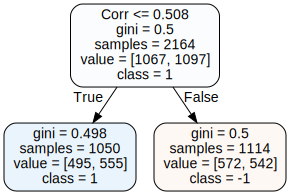

In [172]:
print('Classes: ', cart.classes_)
print('Tree Depth: ', cart.tree_.max_depth)
print('No. of leaves: ', cart.tree_.n_leaves)
print('No. of features: ', cart.n_features_in_)
print("")

score_te = cart_model.score(x_test, y_test)
print('Accuracy Score: ', score_te)
print(classification_report(y_test, pred_labels_te))

dot_data = tree.export_graphviz(cart, out_file=None, 
                                feature_names=X.columns, 
                                class_names=[str(list(cart.classes_)[0]), str(list(cart.classes_)[1])],
                                filled=True, 
                                rounded=True, 
                               ) 
graph = graphviz.Source(dot_data)
graph

##SVM

In [173]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [174]:
svm = SVC().fit(x_train, y_train)

In [175]:
predictionsvm = svm.predict(x_test)
print(confusion_matrix(y_test,predictionsvm))
print(classification_report(y_test,predictionsvm))

[[ 69 200]
 [ 64 209]]
              precision    recall  f1-score   support

          -1       0.52      0.26      0.34       269
           1       0.51      0.77      0.61       273

    accuracy                           0.51       542
   macro avg       0.51      0.51      0.48       542
weighted avg       0.51      0.51      0.48       542



In [176]:
df['Predicted_Signal'] = svm.predict(X)
df['Return'] = df.Close.pct_change()
df['Strategy_Return'] = df.Return *df.Predicted_Signal.shift(1)
df['Cum_Ret'] = df['Return'].cumsum()
df['Cum_Strategy'] = df['Strategy_Return'].cumsum()
clean_dataset(df)

,Open,High,Low,Close,S_10,Corr,RSI,Open-Close,Open-Open,High-Low,Predicted_Signal,Return,Strategy_Return,Cum_Ret,Cum_Strategy
Date,,,,,,,,,,,,,,,
2005-10-27 00:00:00-04:00,8.881709,8.893913,8.759168,8.793540,8.193414,0.857803,73.088076,0.028893,0.257036,0.134746,1.0,-0.006696,-0.006696,-0.006696,-0.006696
2005-10-28 00:00:00-04:00,8.848583,8.940240,8.842357,8.920813,8.306540,0.845235,75.338007,0.055043,-0.033126,0.097883,1.0,0.014473,0.014473,0.007778,0.007778
2005-10-31 00:00:00-05:00,8.972369,9.333765,8.954188,9.268758,8.453863,0.868553,80.332643,0.051557,0.123786,0.379577,1.0,0.039004,0.039004,0.046781,0.046781
2005-11-01 00:00:00-05:00,9.261785,9.561661,9.190801,9.449083,8.625046,0.883001,82.386732,-0.006973,0.289415,0.370860,1.0,0.019455,0.019455,0.066237,0.066237
2005-11-02 00:00:00-05:00,9.506866,9.589058,9.394039,9.456555,8.808309,0.884409,82.471021,0.057783,0.245082,0.195019,1.0,0.000791,0.000791,0.067027,0.067027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-02 00:00:00-05:00,37.229500,37.700001,37.154999,37.525002,38.081100,-0.106144,41.952598,-0.166500,-0.642502,0.545002,1.0,0.003450,0.003450,1.915018,1.450315
2016-12-05 00:00:00-05:00,37.885502,38.195000,37.645000,38.125999,38.091000,-0.125955,51.503111,0.360500,0.656002,0.549999,1.0,0.016016,0.016016,1.931034,1.466331
2016-12-06 00:00:00-05:00,38.236500,38.441502,37.867001,37.955502,38.040550,-0.029089,48.963763,0.110500,0.350998,0.574501,1.0,-0.004472,-0.004472,1.926562,1.461859


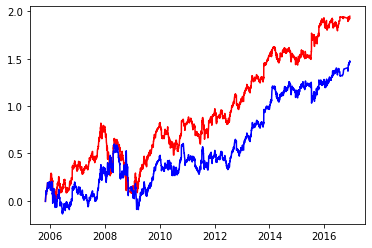

In [177]:
plt.plot(df['Cum_Ret'],color='red')
plt.plot(df['Cum_Strategy'],color='blue')

##Graph Based Clustering

In [178]:
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler ,normalize
from sklearn.decomposition import PCA

In [179]:
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(df) 
  
X_normalized = normalize(X_scaled) 
  
X_normalized = pd.DataFrame(X_normalized) 
  
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(X_normalized) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['Open-Close', 'High-Low'] 

Text(0, 0.5, 'WCSS')

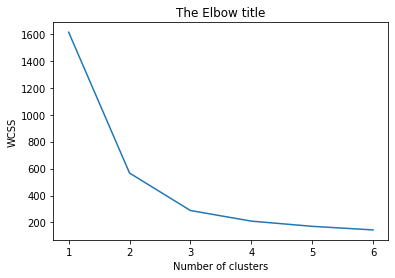

In [180]:
wcss=[]
for i in range(1,7):
  kmeans = KMeans(i).fit(X_principal)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1,7)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [181]:
kmeans = KMeans(3).fit(X_principal)

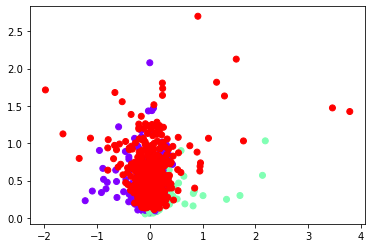

In [182]:
identified_clusters = kmeans.fit_predict(X_principal)
data_with_clusters = df.copy()
data_with_clusters['Clusters'] = identified_clusters 
plt.scatter(data_with_clusters['Open-Close'],data_with_clusters['High-Low'],c=data_with_clusters['Clusters'],cmap='rainbow')

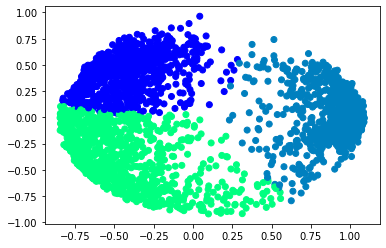

In [183]:
spectral_model_nn = SpectralClustering(n_clusters = 3, affinity ='nearest_neighbors') 
labels_nn = spectral_model_nn.fit_predict(X_principal)
plt.scatter(X_principal['Open-Close'], X_principal['High-Low'],  
           c =labels_nn, cmap =plt.cm.winter) 
plt.show() 

##DBSCAN

In [184]:
import plotly.graph_objs as go
from itertools import product

from sklearn.cluster import DBSCAN
from sklearn import metrics

In [185]:
# to find eps and min points https://stats.stackexchange.com/questions/88872/a-routine-to-choose-eps-and-minpts-for-dbscan , https://towardsdatascience.com/explaining-dbscan-clustering-18eaf5c83b31
df_scale = pd.DataFrame(X_scaled, columns=df.columns)
df_scale.head()

,Open,High,Low,Close,S_10,Corr,RSI,Open-Close,Open-Open,High-Low,Predicted_Signal,Return,Strategy_Return,Cum_Ret,Cum_Strategy
0,-1.123692,-1.134894,-1.124237,-1.133119,-1.204317,0.961790,1.287897,0.042990,0.734468,-0.940327,0.577208,-0.395530,-0.385978,-1.678551,-1.283161
1,-1.127634,-1.129416,-1.114266,-1.117974,-1.190792,0.937012,1.436182,0.164742,-0.132043,-1.099675,0.577208,0.733462,0.742655,-1.652036,-1.250305
2,-1.112903,-1.082878,-1.100861,-1.076570,-1.173178,0.982984,1.765360,0.148509,0.336543,0.118027,0.577208,2.041708,2.050486,-1.580582,-1.161763
3,-1.078463,-1.055927,-1.072499,-1.055112,-1.152711,1.011469,1.900738,-0.123993,0.831162,0.080347,0.577208,0.999149,1.008258,-1.544941,-1.117598
4,-1.049298,-1.052687,-1.048137,-1.054223,-1.130800,1.014245,1.906293,0.177499,0.698769,-0.679779,0.577208,0.003742,0.013167,-1.543492,-1.115803


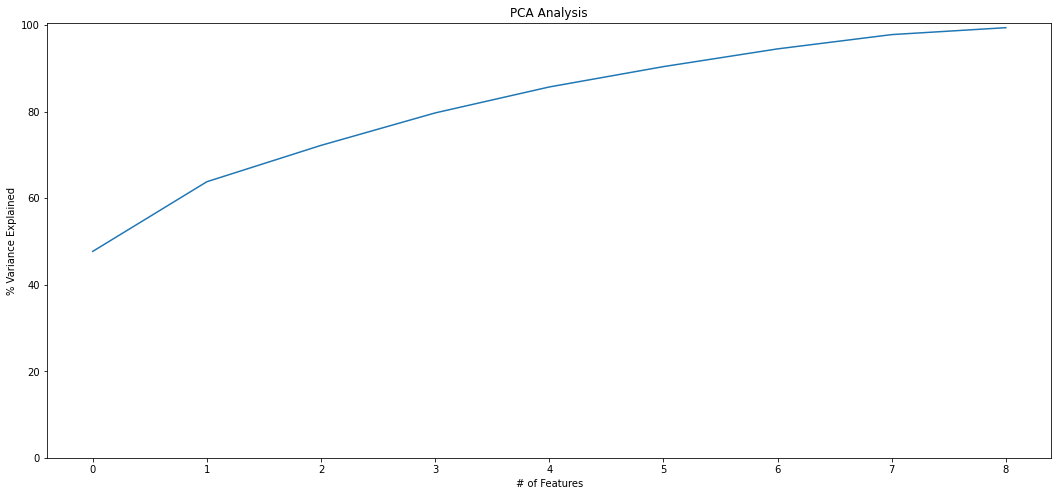

In [186]:
pca = PCA(n_components=9)
pca.fit(df_scale)
variance = pca.explained_variance_ratio_ 
var=np.cumsum(np.round(variance, 3)*100)
plt.figure(figsize=(18,8))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(0,100.5)
plt.plot(var)

In [187]:
pca = PCA(n_components=3)
pca.fit(df_scale)
pca_scale = pca.transform(df_scale)
pca_df = pd.DataFrame(pca_scale, columns=['pc7', 'pc8', 'pc9'])
print(pca.explained_variance_ratio_)

[0.47683122 0.16142682 0.08371335]


In [188]:
Scene = dict(xaxis = dict(title  = 'Open-Close'),yaxis = dict(title  = 'Open-Open'),zaxis = dict(title  = 'High-Low'))
trace = go.Scatter3d(x=pca_df.iloc[:,0], y=pca_df.iloc[:,1], z=pca_df.iloc[:,2], mode='markers',marker=dict(colorscale='Greys', opacity=0.3, size = 10, ))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene, height = 1000,width = 1000)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

In [189]:
pca_eps_values = np.arange(0.2,1.5,0.1) 
pca_min_samples = np.arange(2,5) 
pca_dbscan_params = list(product(pca_eps_values, pca_min_samples))

pca_no_of_clusters = []
pca_sil_score = []
pca_epsvalues = []
pca_min_samp = []

for p in pca_dbscan_params:
    pca_dbscan_cluster = DBSCAN(eps=p[0], min_samples=p[1]).fit(pca_df)
    pca_epsvalues.append(p[0])
    pca_min_samp.append(p[1])
    pca_no_of_clusters.append(len(np.unique(pca_dbscan_cluster.labels_)))
    pca_sil_score.append(metrics.silhouette_score(pca_df, pca_dbscan_cluster.labels_))

pca_eps_min = list(zip(pca_no_of_clusters, pca_sil_score, pca_epsvalues, pca_min_samp))
pca_eps_min_df = pd.DataFrame(pca_eps_min, columns=['no_of_clusters', 'silhouette_score', 'epsilon_values', 'minimum_points'])
pca_eps_min_df

,no_of_clusters,silhouette_score,epsilon_values,minimum_points
0,285,-0.314480,0.2,2
1,132,-0.410803,0.2,3
2,78,-0.483007,0.2,4
3,113,-0.357247,0.3,2
4,56,-0.325250,0.3,3
5,30,-0.252928,0.3,4
6,47,-0.195916,0.4,2
7,24,-0.030541,0.4,3
8,22,-0.029857,0.4,4
9,30,-0.216180,0.5,2


In [190]:
db = DBSCAN(eps=0.5, min_samples=2).fit(pca_df)
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(pca_df, labels))

Estimated number of clusters: 29
Estimated number of noise points: 127
Silhouette Coefficient: -0.216


In [191]:
set(labels)

Scene = dict(xaxis = dict(title  = 'Open-Close'),yaxis = dict(title  = 'Open-Open'),zaxis = dict(title  = 'High-Low'))
labels = db.labels_
trace = go.Scatter3d(x=pca_df.iloc[:,0], y=pca_df.iloc[:,1], z=pca_df.iloc[:,2], mode='markers',marker=dict(color = labels, colorscale='Viridis', size = 10, line = dict(color = 'gray',width = 5)))
layout = go.Layout(scene = Scene, height = 1000,width = 1000)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.update_layout(title="'DBSCAN Clusters (6) Derived from PCA'", font=dict(size=12,))
fig.show()

##Bagging

In [192]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

In [193]:
bagging = RandomForestClassifier(n_estimators= 500)
bagging = bagging.fit(x_train , y_train)

mse = mean_squared_error(y_test, bagging.predict(x_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 2.0221


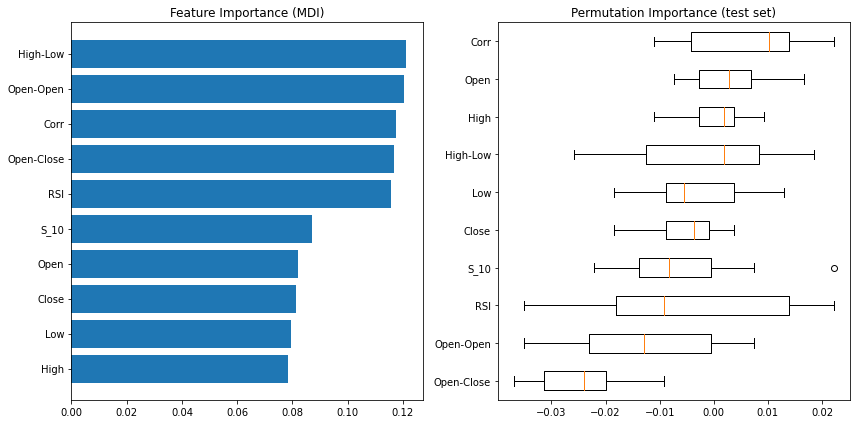

In [194]:
feature_importance = bagging.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(df.columns.values)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    bagging, x_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(df.columns.values)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

##Boosting

In [195]:
from sklearn import ensemble

In [196]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "learning_rate": 0.05,
    "loss": "huber",
    "random_state" : 0, 
}

In [197]:
boosting = ensemble.GradientBoostingRegressor(**params)
boosting.fit(x_train, y_train)

mse = mean_squared_error(y_test, boosting.predict(x_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 1.0717


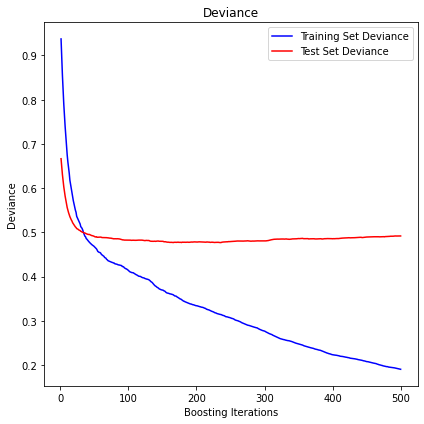

In [198]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(boosting.staged_predict(x_test)):
    test_score[i] = boosting.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    boosting.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

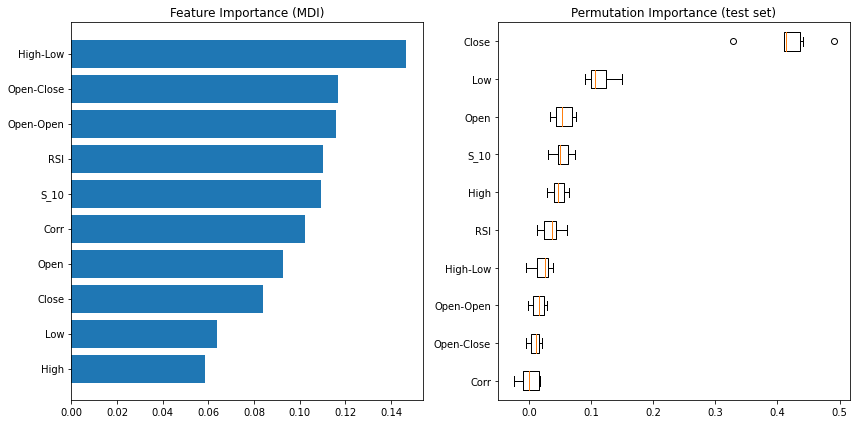

In [199]:
feature_importance = boosting.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(df.columns.values)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    boosting, x_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(df.columns.values)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()